# Day3_work_通し課題：Kickstarter 

あるクラウドファンディングが成功するかを事前に予測するモデル作成する

## Day3を通して実装したこと

- 変数追加：1日の目標金額,"name"の加工
- 特徴選択：埋め込み法
- 決定木：ランダムフォレスト
- ニューラルネットワーク

## 結果

- ニューラルネットワークは、全く学習しなかった
- Day2と比べてでも余り学習率の変化はなかった
- 説明変数を増やすことで、学習率の変化が大きくなるのではないかと感じた

#### 必要ライブラリのインポート

In [140]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.svm
import re
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from IPython.display import Image
from sklearn.externals.six import StringIO

#### グラフの関数化

In [141]:
#散布図
def plot_scatter(df, col_nm_x, col_nm_y):
    plt.scatter(df[col_nm_x], df[col_nm_y])
    plt.xlabel(col_nm_x)
    plt.ylabel(col_nm_y)
    plt.show()
    return

#箱ひげ図
def plot_box(df, col_nm):
    df[col_nm].plot.box()
    plt.show()
    return

#ヒストグラム
def plot_hist(df, col_nm):
    plt.figure(figsize=(12,4))
    sns.distplot(df[col_nm]);
    return

#ヒートマップ
def plot_heatmap(df, var):
    plt.figure(figsize=(20, 20))
    sns.clustermap(df[var].corr(),annot=True,fmt='.2f')
    return

#ペアプロット
def plot_pairplot(df, var, hue):
    sns.pairplot(df, hue=hue, vars=var, size=5)
    return

#ストリッププロット
def plot_strip(df, col_x, col_y):
    sns.stripplot(data=df, x=col_x, y=col_y)
    return

#カテゴリプロット
def plot_cat_count(df, x, hue):
    sns.catplot(data=df, kind='count', x=x, hue=hue, height=7)
    return

#カウントプロット
def plot_count(df, col_nm):
    plt.figure(figsize=(20, 20))
    sns.countplot(x=col_nm, data=df)
    return

#### CSVファイル読み込み

In [142]:
#データフレームに復元
df_csv = pd.read_csv("./ks-projects-201801.csv")
df_csv.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


#### 空白値確認

In [143]:
#空白値の確認
df_csv.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

#### データ数の確認

In [144]:
df_csv.count()

ID                  378661
name                378657
category            378661
main_category       378661
currency            378661
deadline            378661
goal                378661
launched            378661
pledged             378661
state               378661
backers             378661
country             378661
usd pledged         374864
usd_pledged_real    378661
usd_goal_real       378661
dtype: int64

#### 基本統計データの確認（最小値・最大値・平均値）

In [145]:
#describe：基本統計算出（数値のみ）min：最小,max；最大,mean：平均
df_csv.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


#### 目的変数の調査

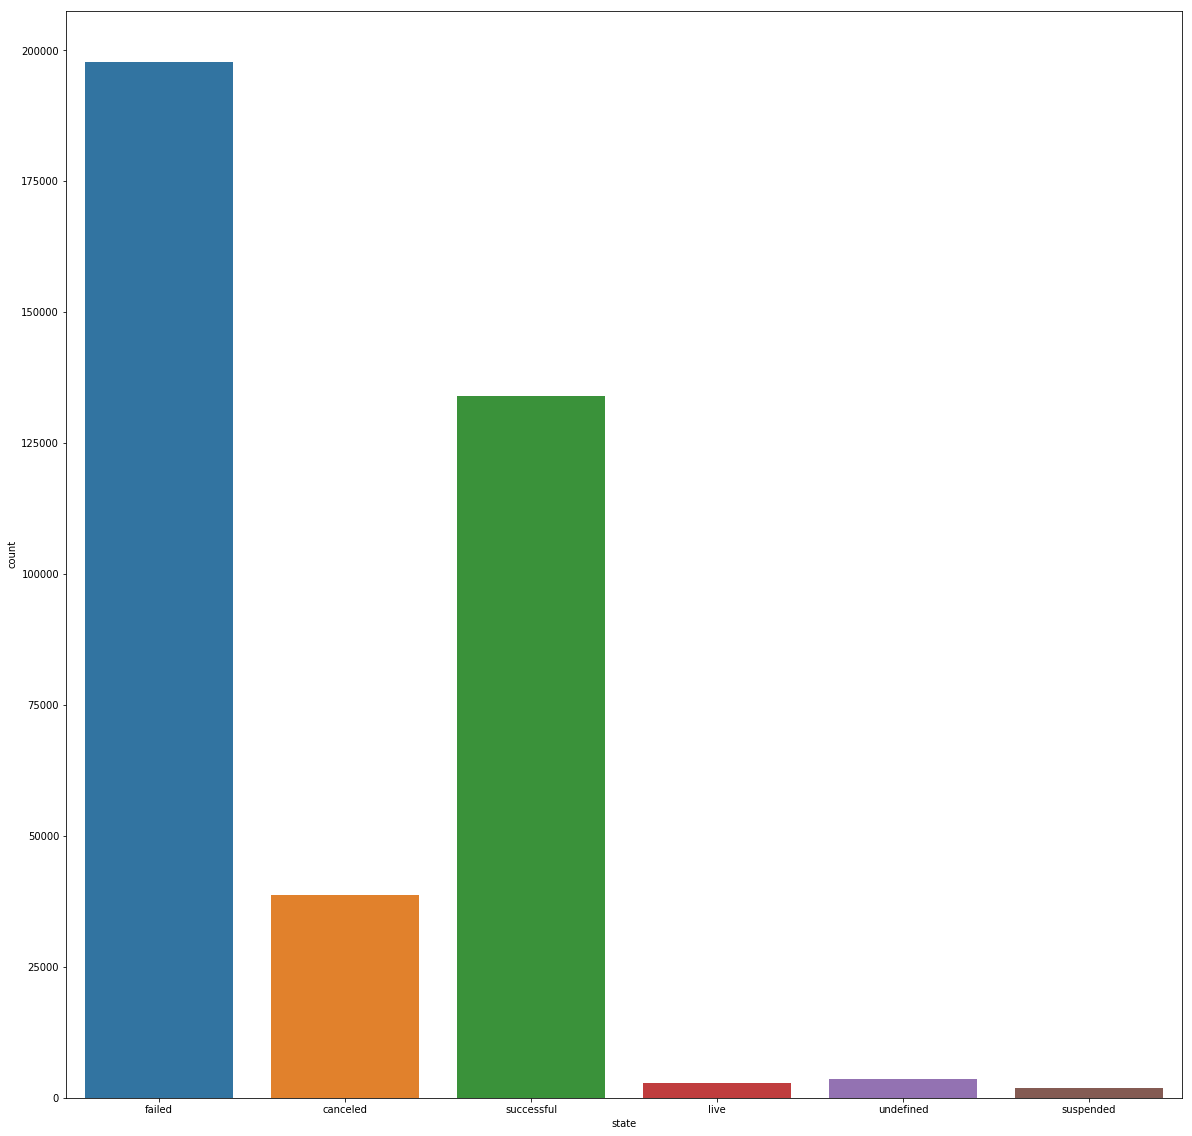

In [146]:
plot_count(df_csv,'state')

#### 外れ値が疑われるデータの確認

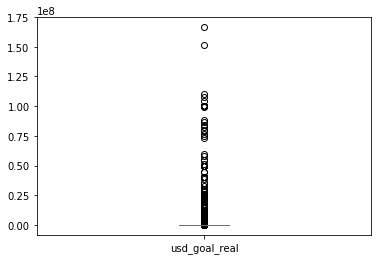

In [147]:
#対数化前:箱ひげ図
plot_box(df_csv,'usd_goal_real')

#### カテゴリ数のばらつき確認

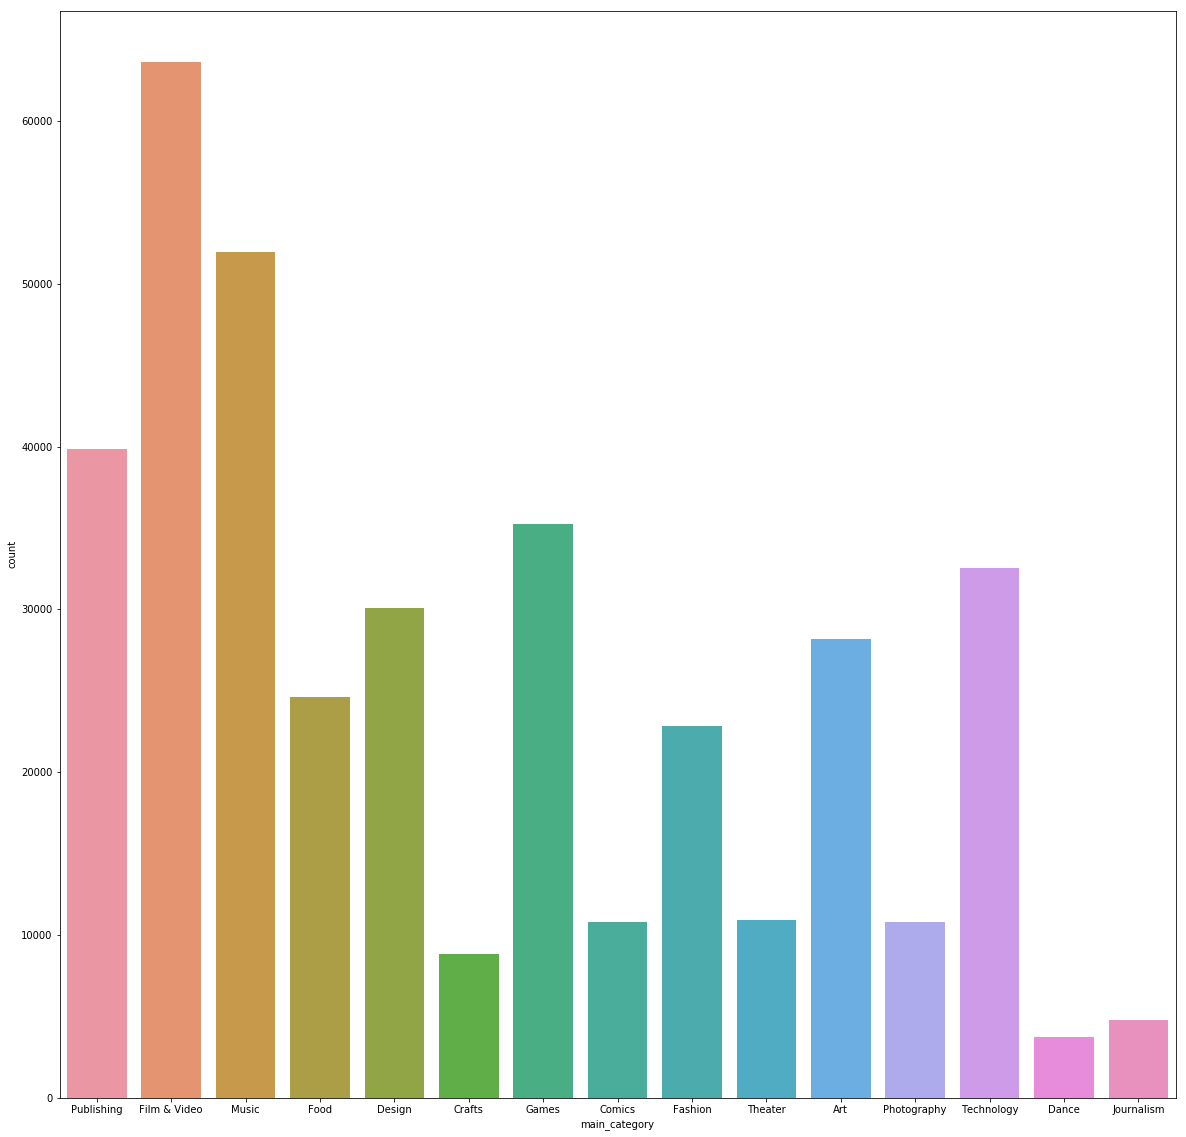

In [148]:
plot_count(df_csv,'main_category')

#### 説明変数のラベル化　（ダミー変数の処理方法が分からなかった）

In [149]:
#質的変数を量的変数に変換:決定木モデルならone-hotよりlabelのほうがよい?
#そもそもダミー変数だらけになる
from sklearn.preprocessing import LabelEncoder

#ラベルを覚えさせる:訓練データのラベルだけを覚えさせる
le_main = LabelEncoder().fit(df_csv['main_category'])
le_cat = LabelEncoder().fit(df_csv['category'])
le_cur = LabelEncoder().fit(df_csv['currency'])
le_cou = LabelEncoder().fit(df_csv['country'])

#ラベルを整数に変換
def category_to_labels(df):
    df['main_category'] = le_main.transform(df['main_category'])
    df['category'] = le_cat.transform(df['category'])
    df['currency'] = le_cur.transform(df['currency'])
    df['country'] = le_cou.transform(df['country'])
    return df

In [150]:
#ダミー変数処理:処理方法がわからなかったため、ラベルを使用した。
#def convert_variables(df_csv):
    #df_csv=pd.get_dummies(df_csv, columns=["category", "main_category", "currency","country"], sparse=True)

#ダミー変数化したため、元の列が不必要となり、削除する
#df_csv.drop('category', axis=1, inplace=True)
#df_csv.drop('main_category', axis=1, inplace=True)
#df_csv.drop('currency', axis=1, inplace=True)
#df_csv.drop('country', axis=1, inplace=True)
#df_csv.head()


#### 目的変数の真理値に変換と必要のない説明変数削除

In [151]:
#成功か不成功かを判断したいのでsuccessful,failed以外は除外、下2行で#目的変数を真理値に変換
def convert_state(df):
    df = df[df['state'] != 'undefined']
    df = df[df['state'] != 'live']
    df = df[df['state'] != 'suspended']
    df = df[df['state'] != 'canceled']
    df.loc[df['state'] == 'failed', 'state'] = 0
    df.loc[df['state'] == 'successful', 'state'] = 1
    return df

In [152]:
#必要でなさそうな変数削除
def drop_colomn(df):
    df.drop('ID', axis=1, inplace=True)
    #df.drop('name', axis=1, inplace=True)
    df.drop('pledged', axis=1, inplace=True)
    df.drop('backers', axis=1, inplace=True)
    df.drop('usd pledged', axis=1, inplace=True)
    df.drop('usd_pledged_real', axis=1, inplace=True)
    return df

#### 対数化

In [153]:
#前処理：対数化
def convert_log(df):   
    log_cols = ['usd_goal_real','goal']
    for l in log_cols:
        df[l] = np.log(df[l].astype(np.float64))
        df[l]= df[l].replace([np.inf, -np.inf], np.nan)
        df[l] = df[l].fillna(0)
    return df

In [154]:
#対数化後：箱ひげ図
#plot_box(df_csv,'usd_goal_real')
#対数化後：ヒストグラム
#plot_hist(df_csv,'usd_goal_real')

#### 日付差分の説明変数作成（span）

In [155]:
#日付データをfloatに変換
#df_csv['deadline'] = pd.to_datetime(df_csv['deadline'], format='%Y-%m-%d %H:%M:%S')
#df_csv['launched'] = pd.to_datetime(df_csv['launched'], format='%Y-%m-%d %H:%M:%S')
#df_csv['deadline'] = df_csv['deadline'].map(pd.Timestamp.timestamp)
#df_csv['launched'] = df_csv['launched'].map(pd.Timestamp.timestamp)
#df_csv.head()

In [156]:
#日付差分
def create_span_column(df):
    df['deadline'] = pd.to_datetime(df['deadline'], format='%Y-%m-%d %H:%M:%S')
    df['launched'] = pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')
    df['span'] = df['deadline'] - df['launched']
    df['span'] = df['span'].dt.days
    return df

In [157]:
#数値じゃないため、launched,deadlineを削除
def drop_date_column(df):
    df.drop('launched', axis=1, inplace=True)
    df.drop('deadline', axis=1, inplace=True)
    return df

#### 1日の目標金額

In [158]:
#1日の目標金額
def create_targetamount_column(df):
    df['targetamount'] = df['usd_goal_real'] / df['span']
    df['targetamount']= df['targetamount'].replace([np.inf, -np.inf], np.nan)
    df['targetamount'] = df['targetamount'].fillna(0)
    return df

#### nameの加工

In [159]:
#スペースの個数で単語数と長さを計る
def create_name_space_count_column(df):
    df["name_space_count"] = df.name.str.count(" ")
    df['name_space_count'] = df['name_space_count'].fillna(0)
    df.drop('name', axis=1, inplace=True)
    #df['name_space_count'] = 0
    #for i in range(len(df)):
    #    print(i)
    #    if df.iloc[i,df.columns.get_loc('name')] is not None:
    #        name_str = str(df.columns.get_loc('name'))
    #        df.iloc[i,df.columns.get_loc('name_space_count')] = name_str.count(' ')
    #        #df.iloc[i,df.columns.get_loc('name_space_count')] = len(re.findall(r'[ ]',  name_str))
    return df

#### 前処理実行

In [160]:
def preprocess(df):
    df = category_to_labels(df)
    df = convert_state(df)
    df = drop_colomn(df)
    df = convert_log(df)
    df = create_span_column(df)
    df = drop_date_column(df)
    df = create_targetamount_column(df)
    df = create_name_space_count_column(df)
    return df

In [161]:
df_csv = preprocess(df_csv)

In [162]:
df_csv.head()

,category,main_category,currency,goal,state,country,usd_goal_real,span,targetamount,name_space_count
0,108,12,5,6.907755,0,9,7.335601,58,0.126476,5.0
1,93,6,13,10.308953,0,22,10.308953,59,0.174728,7.0
2,93,6,13,10.714418,0,22,10.714418,44,0.243509,2.0
3,90,10,13,8.517193,0,22,8.517193,29,0.293696,6.0
5,123,7,13,10.819778,1,22,10.819778,34,0.318229,2.0


In [163]:
df_csv.isnull().sum()

category            0
main_category       0
currency            0
goal                0
state               0
country             0
usd_goal_real       0
span                0
targetamount        0
name_space_count    0
dtype: int64

#### 訓練データとテストデータの分割（ホールドアウト法）

In [164]:
#訓練データ・テストデータ分割
test_size = 0.2
X = df_csv.values
X_train, X_test = train_test_split(X, test_size=test_size, random_state=1234) 

In [165]:
# 操作しづらいためデータフレーム化
df_train = pd.DataFrame(data=X_train, columns=df_csv.columns)
df_test = pd.DataFrame(data=X_test, columns=df_csv.columns)

#### 標準化

In [166]:
#標準化処理
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_rows = ['goal','usd_goal_real','span']
#訓練データ用
for row in df_rows:
    df_train[row] = stdsc.fit_transform(df_train[[row]].values)
#テストデータ用
for row in df_rows:
    df_test[row] = stdsc.transform(df_test[[row]].values)

#df_train.head()

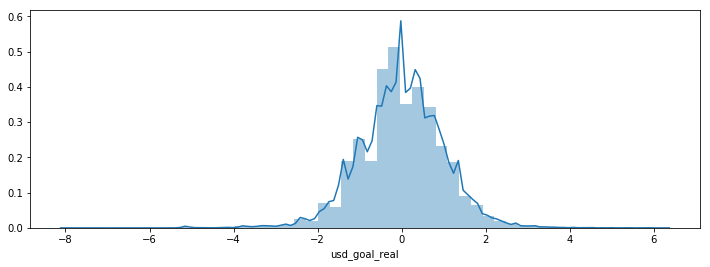

In [167]:
#標準化後のグラフ
plot_hist(df_train,'usd_goal_real')

#### 相関関係確認

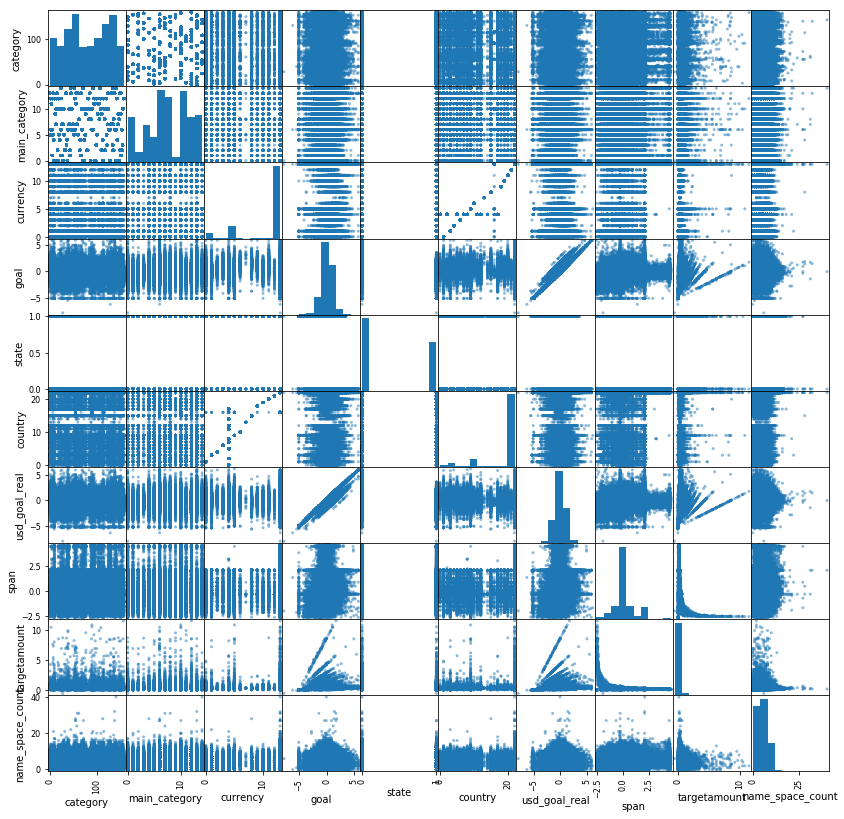

In [168]:
#相関係数（散布図）
df_csv.corr()
pd.plotting.scatter_matrix(df_train, figsize=(14,14))
plt.show()

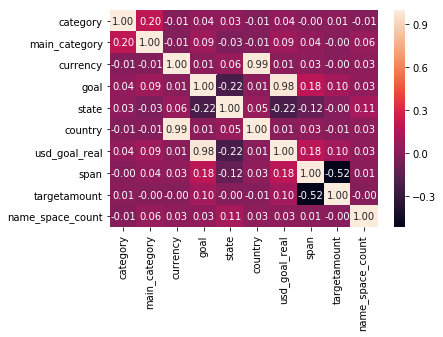

In [169]:
#相関係数（ヒートマップ）
sns.heatmap(df_train.corr(),annot=True,fmt='.2f')

#### 目的変数と説明変数の切り離し

In [170]:
#訓練データ・テストデータ分割
X_train = df_train.drop('state', axis=1).values
y_train = df_train["state"].values
X_test = df_test.drop('state', axis=1).values
y_test = df_test["state"].values

#### 特徴選択（埋め込み法）

In [171]:
estimator = LassoCV(normalize=True, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [172]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [173]:
# 削除すべき特徴の名前を取得 
#removed_idx  = ~sfm.get_support()
#df_train.columns[removed_idx]

In [174]:
# LASSOで得た各特徴の係数の値を確認してみよう
# 係数の絶対値を取得
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([0.000529  , 0.00319118, 0.01753771, 0.03998809, 0.00634441,
       0.06200747, 0.04774769, 0.0743925 , 0.02108392])

In [175]:
# 係数を棒グラフで表示
#plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_train.columns.values)
#plt.show()

In [176]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
# Importance:重要度,Features:特徴量
#print(clf.feature_importances_)
#pd.DataFrame(clf.feature_importances_, index=iris.feature_names).plot.bar(figsize=(7,2))
#plt.ylabel("Importance")
#plt.xlabel("Features")
#plt.show()

#### 相関が高い変数の削除

In [177]:
#countryとcurrency：currencyは、USDドルに変換済みのため不要
#usd_goal_realとgoal:goalは、別の通貨が混じっているため必要ない
def drop_same_column(df):
    df.drop('currency', axis=1, inplace=True)
    df.drop('goal', axis=1, inplace=True)
    return df

In [178]:
df_train = drop_same_column(df_train)
df_test = drop_same_column(df_test)

## モデル作成

In [179]:
#訓練データ・テストデータ分割
X_train = df_train.drop('state', axis=1).values
y_train = df_train["state"].values
X_test = df_test.drop('state', axis=1).values
y_test = df_test["state"].values

#### 決定木（ランダムフォレスト）

In [180]:
from sklearn.ensemble import RandomForestClassifier
def RF(_n_estimators, _max_depth, _criterion, _min_samples_leaf, _min_samples_split):
    clf = RandomForestClassifier(n_estimators=_n_estimators, 
                                 max_depth=_max_depth, 
                                 criterion=_criterion,
                                 min_samples_leaf=_min_samples_leaf, 
                                 min_samples_split=_min_samples_split, 
                                 random_state=1234)
    return clf

#### ロジスティクス回帰


In [181]:
# ロジスティック回帰
from  sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix 
def LOG(_loss, _max_iter, _tol, _penalty):
    clf = SGDClassifier(loss=_loss, max_iter=_max_iter, fit_intercept=True, random_state=1234, tol=_tol, penalty=_penalty)
    return clf

In [182]:
def predict(X, y, clf):
    # ラベルを予測
    y_pred = clf.predict(X)
    # 正答率を計算:訓練誤差
    accuracy =  accuracy_score(y, y_pred)
    # Precision, Recall, F1-scoreを計算
    precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

    # Precision, Recall, F1-scoreを表示
    print('--正答率（Train_Accuracy） = {:.3f}%'.format(100 * accuracy))
    print('--適合率（Train_Precision） = {:.3f}%'.format(100 * precision[1]))
    print('--再現率（Train_Recall） = {:.3f}%'.format(100 * recall[1]))
    
    # クロス集計
    print('--クロス集計')
    print(pd.DataFrame(confusion_matrix(y, y_pred), 
                        index=['正解 : 失敗', '正解 : 成功'], 
                        columns=['予測 : 失敗', '予測 : 成功']))

In [183]:
#モデル作成
models = []
model_nms = []
#ランダムフォレスト
#def RF(_n_estimators, _max_depth, _criterion, _min_samples_leaf, _min_samples_split):
model_nms.append('RF_1')
models.append(RF(1, 100, "gini", 2, 2))

model_nms.append('RF_2')
models.append(RF(3, 100, "gini", 2, 2))

model_nms.append('RF_3')
models.append(RF(10, 100, "gini", 2, 2))

model_nms.append('RF_4')
models.append(RF(20, 100, "gini", 2, 2))

model_nms.append('RF_5')
models.append(RF(1, 50, "gini", 2, 2))

model_nms.append('RF_6')
models.append(RF(3, 100, "gini", 2, 2))

model_nms.append('RF_7')
models.append(RF(10, 200, "gini", 2, 2))

model_nms.append('RF_8')
models.append(RF(20, 500, "gini", 2, 2))
#ロジスティクス回帰
#def LOG(_loss, _max_iter, _tol, _penalty):
model_nms.append('LOG_1')
models.append(LOG('log', 100, 1e-3, None))

model_nms.append('LOG_2')
models.append(LOG('log', 1000, 1e-3, None))

model_nms.append('LOG_3')
models.append(LOG('log', 10000, 1e-3, None))

model_nms.append('LOG_4')
models.append(LOG('log', 100, 1e-1, None))

model_nms.append('LOG_5')
models.append(LOG('log', 1000, 1e-5, None))

model_nms.append('LOG_6')
models.append(LOG('log', 10000, 1e-8, None))

In [184]:
#学習
for model, model_nm in zip(models,model_nms):
    print('=====================================================')
    print('モデル名 : ' + model_nm)
    model = model.fit(X_train, y_train)
    print("score=", model.score(X_train, y_train))
    print('')
    print('訓練誤差')
    predict(X_train,y_train, model)
    print('')
    print('汎化誤差')
    predict(X_test,y_test, model)
    print('=====================================================')

モデル名 : RF_1
score= 0.741433632320796

訓練誤差
--正答率（Train_Accuracy） = 74.143%
--適合率（Train_Precision） = 70.772%
--再現率（Train_Recall） = 61.480%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗   130734    27257
正解 : 成功    41351    65998

汎化誤差
--正答率（Train_Accuracy） = 57.011%
--適合率（Train_Precision） = 46.706%
--再現率（Train_Recall） = 50.896%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗    24276    15452
正解 : 成功    13065    13542
モデル名 : RF_2
score= 0.8047636994045376

訓練誤差
--正答率（Train_Accuracy） = 80.476%
--適合率（Train_Precision） = 78.794%
--再現率（Train_Recall） = 70.795%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗   137538    20453
正解 : 成功    31351    75998

汎化誤差
--正答率（Train_Accuracy） = 56.869%
--適合率（Train_Precision） = 46.979%
--再現率（Train_Recall） = 58.556%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗    22144    17584
正解 : 成功    11027    15580
モデル名 : RF_3
score= 0.8492198688475164

訓練誤差
--正答率（Train_Accuracy） = 84.922%
--適合率（Train_Precision） = 84.618%
--再現率（Train_Recall） = 76.668%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 :

C:\Users\a-miyamoto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


score= 0.604224768221904

訓練誤差
--正答率（Train_Accuracy） = 60.422%
--適合率（Train_Precision） = 57.169%
--再現率（Train_Recall） = 8.669%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗   151019     6972
正解 : 成功    98043     9306

汎化誤差
--正答率（Train_Accuracy） = 57.339%
--適合率（Train_Precision） = 45.835%
--再現率（Train_Recall） = 34.987%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗    28727    11001
正解 : 成功    17298     9309
モデル名 : LOG_2
score= 0.5630247983719002

訓練誤差
--正答率（Train_Accuracy） = 56.302%
--適合率（Train_Precision） = 47.484%
--再現率（Train_Recall） = 75.583%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗    68255    89736
正解 : 成功    26211    81138

汎化誤差
--正答率（Train_Accuracy） = 41.616%
--適合率（Train_Precision） = 40.673%
--再現率（Train_Recall） = 99.335%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗     1176    38552
正解 : 成功      177    26430
モデル名 : LOG_3
score= 0.5630247983719002

訓練誤差
--正答率（Train_Accuracy） = 56.302%
--適合率（Train_Precision） = 47.484%
--再現率（Train_Recall） = 75.583%
--クロス集計
         予測 : 失敗  予測 : 成功
正解 : 失敗    6825

#### ニューラルネットワーク

In [185]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

def NN_1(col_cnt):
    model = Sequential()
    model.add(Dense(10, activation='relu', input_dim=col_cnt))
    model.add(Dense(5, activation='relu', input_dim=10))
    model.add(Dense(1, activation='softmax'))#最終層のactivationは変更しないこと
    # ------ 最適化手法 ------
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def NN_2(col_cnt):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=col_cnt))
    model.add(Dense(32, activation='relu', input_dim=16))
    model.add(Dense(1, activation='softmax'))
    # ------ 最適化手法 ------
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def NN_3(col_cnt):
    model = Sequential()
    model.add(Dense(16, activation='relu', input_dim=col_cnt))
    model.add(Dense(32, activation='relu', input_dim=16))
    model.add(Dense(64, activation='relu', input_dim=32))
    model.add(Dense(1, activation='softmax'))
    # ------ 最適化手法 ------
    sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [189]:
#ニューラルネット
nn_models = []
col_cnt = len(df_train.columns)-1
nn_models.append(NN_1(col_cnt))
nn_models.append(NN_2(col_cnt))
nn_models.append(NN_3(col_cnt))

In [190]:
df_epochs = []
for nn_model in nn_models:
    # 計算の実行
    nn_model = nn_model.fit(X_train, y_train,
                              epochs=50,
                              batch_size=20,validation_data=(X_test, y_test))
    # 各epochにおける損失と精度をdfに入れる
    df_epochs.append(pd.DataFrame(nn_model.history))

Train on 265340 samples, validate on 66335 samples
Epoch 1/50
265340/265340 [==============================] - 27s 103us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 2/50
265340/265340 [==============================] - 28s 104us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 3/50
265340/265340 [==============================] - 22s 83us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 4/50
265340/265340 [==============================] - 20s 74us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 5/50
265340/265340 [==============================] - 19s 72us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 6/50
265340/265340 [==============================] - 19s 72us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 7/50
265340/265340 [==============================] - 29s 110us/sample - loss: 9.1298 - a

265340/265340 [==============================] - 22s 82us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 8/50
265340/265340 [==============================] - 21s 80us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 9/50
265340/265340 [==============================] - 22s 83us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 10/50
265340/265340 [==============================] - 23s 88us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 11/50
265340/265340 [==============================] - 24s 92us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 12/50
265340/265340 [==============================] - 22s 85us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 13/50
265340/265340 [==============================] - 22s 84us/sample - loss: 9.1298 - acc: 0.4046 - val_loss: 9.1831 - val_acc: 0.4011
Epoch 14/50
2

KeyboardInterrupt: 

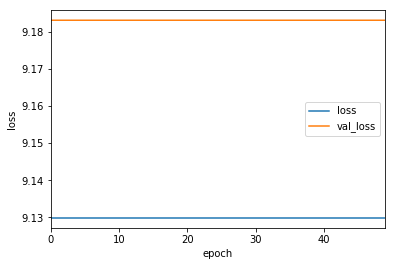

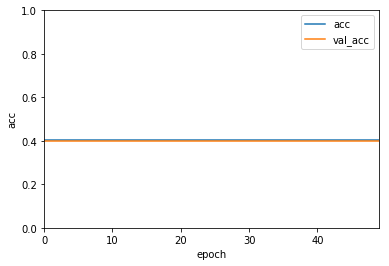

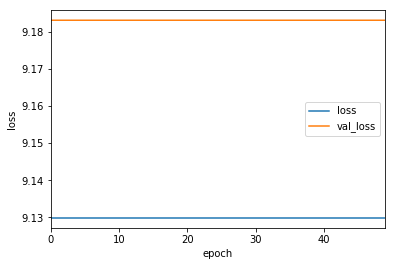

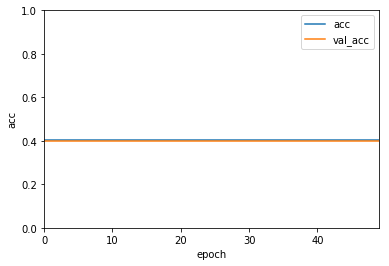

In [191]:
for df_epoch in df_epochs:
    # グラフ化
    df_epoch[["loss", "val_loss"]].plot()
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.show()
    
    df_epoch[["acc", "val_acc"]].plot()
    plt.ylabel("acc")
    plt.xlabel("epoch")
    plt.ylim([0,1.0])
    plt.show()